In [46]:
#Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from databento import DBNStore
import mplfinance as mpf
import numpy as np
np.NaN = np.nan
import pandas_ta as ta
import vectorbt as vbt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [47]:
#Import Data (1m OHLCV)

base = Path("/Users/leondabrowski/Downloads/XNAS-20250808-4WWGNNXWUF/")
dbn_file = base / "xnas-itch-20240808-20250807.ohlcv-1m.dbn.zst"

store = DBNStore.from_file(path=str(dbn_file))
df = store.to_df()  

df.index = pd.to_datetime(df.index)
df = df.sort_index()

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())
df.describe()

Shape: (189309, 9)
Columns: ['rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol']
                           rtype  publisher_id  instrument_id    open    high  \
ts_event                                                                        
2024-08-08 08:00:00+00:00     33             2          15144  516.61  516.77   
2024-08-08 08:01:00+00:00     33             2          15144  516.60  516.80   
2024-08-08 08:02:00+00:00     33             2          15144  516.83  517.23   
2024-08-08 08:03:00+00:00     33             2          15144  517.15  517.22   
2024-08-08 08:04:00+00:00     33             2          15144  517.18  517.18   

                              low   close  volume symbol  
ts_event                                                  
2024-08-08 08:00:00+00:00  516.57  516.71     238    SPY  
2024-08-08 08:01:00+00:00  516.60  516.75     160    SPY  
2024-08-08 08:02:00+00:00  516.77  517.23     216    SPY  
2024-08-08 08:

,rtype,publisher_id,instrument_id,open,high,low,close,volume
count,189309.0,189309.0,189309.0,189309.000000,189309.000000,189309.000000,189309.000000,1.893090e+05
mean,33.0,2.0,15144.0,582.906444,583.001033,582.808862,582.906501,1.107763e+04
std,0.0,0.0,0.0,27.916114,27.877579,27.954410,27.915735,2.416762e+04
min,33.0,2.0,15144.0,482.630000,483.160000,481.800000,482.660000,1.000000e+00
25%,33.0,2.0,15144.0,563.020000,563.110000,562.940000,563.020000,3.050000e+02
50%,33.0,2.0,15144.0,586.620000,586.700000,586.520000,586.610000,4.616000e+03
75%,33.0,2.0,15144.0,601.910000,602.020000,601.820000,601.910000,1.361800e+04
max,33.0,2.0,15144.0,641.440000,641.440000,641.440000,641.440000,1.693443e+06


In [48]:
#Reformat df to 4h

df = df.reset_index()
df['ts_event'] = pd.to_datetime(df['ts_event'])
df = df.set_index('ts_event').sort_index()

df = df.resample('4h', label='right', closed='right').agg({
    'open':  'first',
    'high':  'max',
    'low':   'min',
    'close': 'last',
    'volume':'sum'}).dropna()

print(df.head())
print(df.index.name)
df.info()

                             open    high     low   close   volume
ts_event                                                          
2024-08-08 08:00:00+00:00  516.61  516.77  516.57  516.71      238
2024-08-08 12:00:00+00:00  516.60  519.33  516.35  519.19   123452
2024-08-08 16:00:00+00:00  519.19  528.48  518.43  527.69  4764144
2024-08-08 20:00:00+00:00  527.66  531.82  526.65  531.77  5582640
2024-08-09 00:00:00+00:00  531.79  532.07  530.45  531.58   485993
ts_event
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1158 entries, 2024-08-08 08:00:00+00:00 to 2025-08-08 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1158 non-null   float64
 1   high    1158 non-null   float64
 2   low     1158 non-null   float64
 3   close   1158 non-null   float64
 4   volume  1158 non-null   uint64 
dtypes: float64(4), uint64(1)
memory usage: 54.3 KB


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




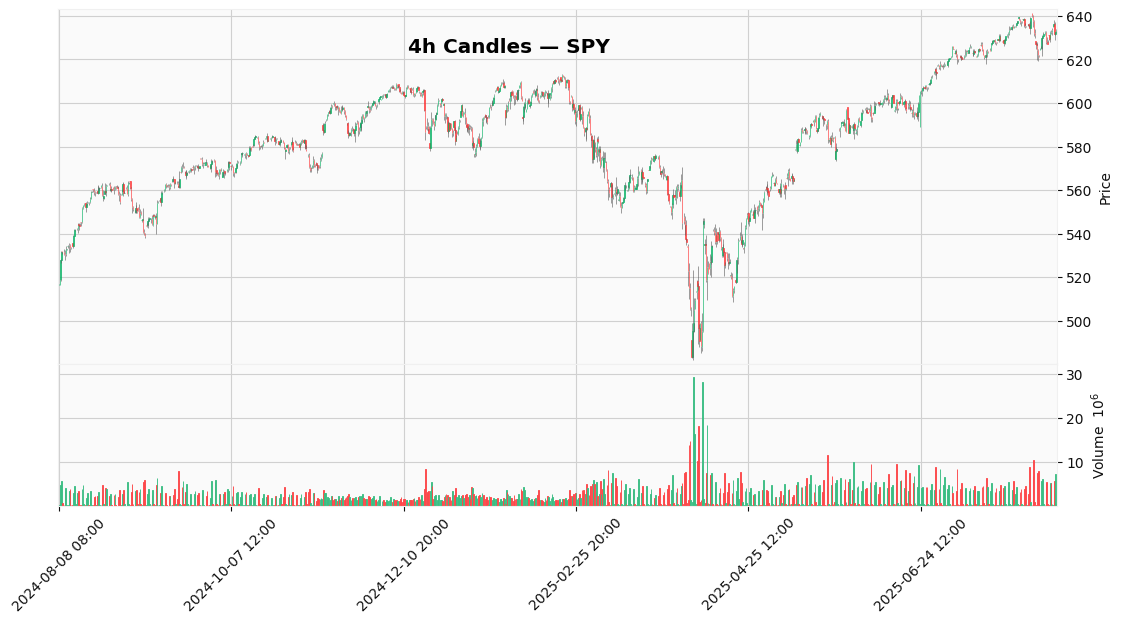

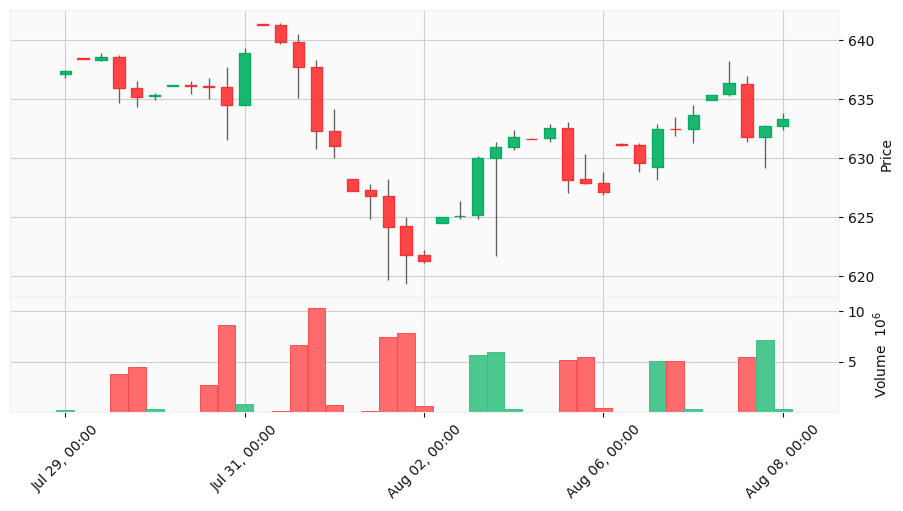

In [49]:
#Visualise the data

df.index = pd.to_datetime(df.index)

mpf.plot(
    df,
    type='candle',              
    style='yahoo',              
    title="4h Candles — SPY",
    ylabel="Price",
    volume=True,                
    figratio=(12, 6),
    datetime_format='%Y-%m-%d %H:%M',
    tight_layout=True
    )

#Zoomed in one for 10 days to check if candlesticks are as expected

df_last10 = df[df.index >= df.index.max() - pd.Timedelta(days=10)]
mpf.plot(df_last10, type='candle', style='yahoo', volume=True, figratio=(12, 6))


In [50]:
#Parameters and settings for strategy

std = 2.0         
sl = 20          
initial_equity = 100000
no_of_shares = 100

#Makes sure timezone is EST

px = df.copy()
px.index = (px.index.tz_localize("UTC") if px.index.tz is None else px.index).tz_convert("US/Eastern")

#Anchors pandas_ta to days

px_naive = px.copy()
px_naive.index = px_naive.index.tz_localize(None)

vwap_naive = ta.vwap(
    high=px_naive["high"], low=px_naive["low"], close=px_naive["close"], volume=px_naive["volume"],
    anchor="D"
).rename("vwap")

sess_naive = pd.Series(px_naive.index.date, index=px_naive.index, name="session")
exp_std_naive = (
    px_naive["close"].groupby(sess_naive).expanding().std().reset_index(level=0, drop=True)
)

upper_naive = (vwap_naive + std * exp_std_naive).rename("upper")
lower_naive = (vwap_naive - std * exp_std_naive).rename("lower")

# put tz=imezone-aware index back

vwap  = vwap_naive.copy();  vwap.index  = px.index
upper = upper_naive.copy(); upper.index = px.index
lower = lower_naive.copy(); lower.index = px.index

sig = pd.concat([px[["open","high","low","close","volume"]], vwap, upper, lower], axis=1).dropna()

In [51]:
#Create state machine

long_entries   = pd.Series(False, index=sig.index)
short_entries  = pd.Series(False, index=sig.index)
long_exits     = pd.Series(False, index=sig.index)
short_exits    = pd.Series(False, index=sig.index)

in_pos   = False
side     = None
entry    = np.nan
entry_t  = None

#Lockouts to block repeated entries while staying above/below the band

can_long  = True   
can_short = True   

trades = []

In [52]:
#Trade logic

for t, row in sig.iterrows():
    o, h, l, c, vw, up, lo = row["open"], row["high"], row["low"], row["close"], row["vwap"], row["upper"], row["lower"]

    if not can_long and c >= lo:
        can_long = True
    if not can_short and c <= up:
        can_short = True

    if not in_pos:
        if can_long and (c < lo):
            in_pos = True; side = "long"; entry = c; entry_t = t
            long_entries.loc[t] = True
            can_long = False  
            continue
        if can_short and (c > up):
            in_pos = True; side = "short"; entry = c; entry_t = t
            short_entries.loc[t] = True
            can_short = False
            continue

    else:
        if side == "long":
            sl_hit = (l <= entry - sl)
            tp_hit = (vw > entry) and (h >= vw)
            if sl_hit:
                long_exits.loc[t] = True
                trades.append(dict(side="long", entry_time=entry_t, entry=entry,
                                   exit_time=t, exit=entry-sl, reason="SL",
                                   pnl=( -sl ) * no_of_shares))
                in_pos=False; side=None; entry=np.nan; entry_t=None
            elif tp_hit:
                long_exits.loc[t] = True
                trades.append(dict(side="long", entry_time=entry_t, entry=entry,
                                   exit_time=t, exit=vw, reason="VWAP",
                                   pnl=(vw-entry)*no_of_shares))
                in_pos=False; side=None; entry=np.nan; entry_t=None

        else: 
            sl_hit = (h >= entry + sl)
            tp_hit = (vw < entry) and (l <= vw)
            if sl_hit:
                short_exits.loc[t] = True
                trades.append(dict(side="short", entry_time=entry_t, entry=entry,
                                   exit_time=t, exit=entry+sl, reason="SL",
                                   pnl=( -sl ) * no_of_shares))
                in_pos=False; side=None; entry=np.nan; entry_t=None
            elif tp_hit:
                short_exits.loc[t] = True
                trades.append(dict(side="short", entry_time=entry_t, entry=entry,
                                   exit_time=t, exit=vw, reason="VWAP",
                                   pnl=(entry-vw)*no_of_shares))
                in_pos=False; side=None; entry=np.nan; entry_t=None


In [53]:
#Vectorbt backtest

pf = vbt.Portfolio.from_signals(
    close=sig["close"],
    entries=long_entries.values,
    exits=long_exits.values,
    short_entries=short_entries.values,
    short_exits=short_exits.values,
    init_cash=initial_equity,
    fees=0.0,
    slippage=0.0001,
    size=no_of_shares,
    allow_partial=False,
    freq="4h"
)
print(pf.stats())

#Save trades to CSV to check

pf.trades.records.to_csv("vbt_trades.csv", index=False)
print(f"Trades saved to vbt_trades.csv ({len(pf.trades.records)} rows)")

#Plot backtest equity curve

#pf.plot() doesnt display nicely in github so its commented out

Start                         2024-08-08 08:00:00-04:00
End                           2025-08-07 20:00:00-04:00
Period                                151 days 08:00:00
Start Value                                    100000.0
End Value                                   103164.2417
Total Return [%]                               3.164242
Benchmark Return [%]                          21.978466
Max Gross Exposure [%]                       775.448637
Total Fees Paid                                     0.0
Max Drawdown [%]                               2.070515
Max Drawdown Duration                  22 days 04:00:00
Total Trades                                         26
Total Closed Trades                                  26
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  76.923077
Best Trade [%]                                 1.568953
Worst Trade [%]                               -3

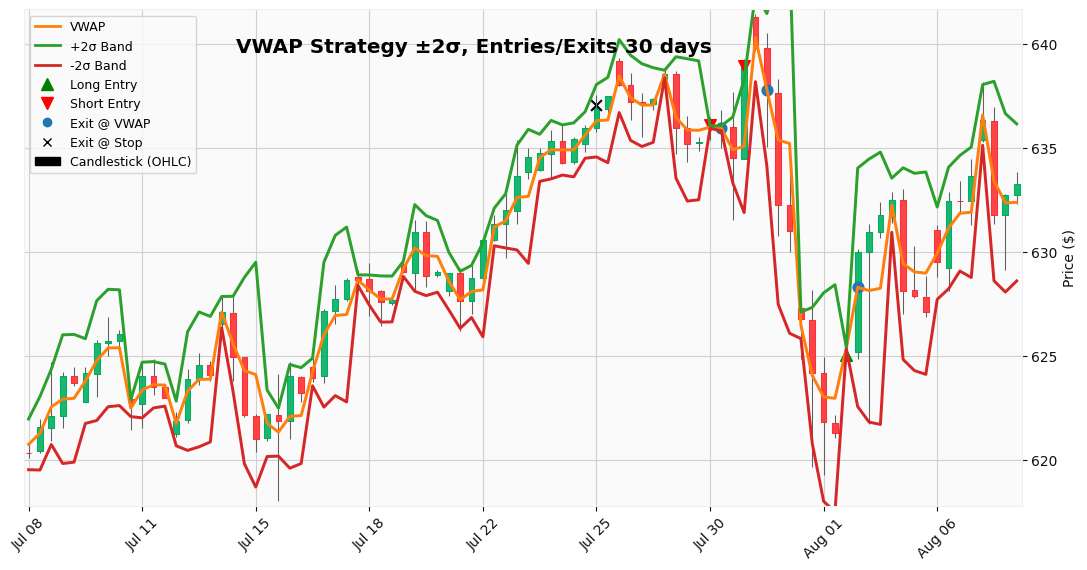

In [54]:
#Plot last 30 days to check visually if logic works
end_ts = sig.index.max()
start_ts = end_ts - pd.Timedelta(days=30)
win = sig.loc[start_ts:end_ts].copy()

candle = win[["open","high","low","close"]].copy()
candle.columns = ["Open","High","Low","Close"]
candle.index = candle.index.tz_localize(None)

trades_df = pd.DataFrame(trades)

def marker_series(times, prices, index):
    s = pd.Series(np.nan, index=index, dtype=float)
    if len(times)==0: return s
    tt = pd.to_datetime(times)
    if isinstance(tt, pd.Series):
        try:
            if getattr(tt.dt, "tz", None) is not None:
                tt = tt.dt.tz_localize(None)
        except AttributeError:
            tt = pd.to_datetime(tt)
    elif isinstance(tt, pd.DatetimeIndex) and tt.tz is not None:
        tt = tt.tz_localize(None)
    nearest = index.get_indexer(pd.DatetimeIndex(tt), method="nearest")
    p = pd.to_numeric(prices, errors="coerce")
    for i, j in enumerate(nearest):
        if 0 <= j < len(s): s.iloc[j] = float(p.iloc[i])
    return s

apds = [
    mpf.make_addplot(win["vwap"].tz_localize(None),  color="tab:orange"),
    mpf.make_addplot(win["upper"].tz_localize(None), color="tab:green"),
    mpf.make_addplot(win["lower"].tz_localize(None), color="tab:red"),
]

if not trades_df.empty:
    L = trades_df[trades_df["side"]=="long"]
    S = trades_df[trades_df["side"]=="short"]
    if not L.empty:
        apds.append(mpf.make_addplot(
            marker_series(L["entry_time"], L["entry"], candle.index),
            type="scatter", marker="^", markersize=70, color="g"))
    if not S.empty:
        apds.append(mpf.make_addplot(
            marker_series(S["entry_time"], S["entry"], candle.index),
            type="scatter", marker="v", markersize=70, color="r"))
    ex_vwap = trades_df[trades_df["reason"]=="VWAP"]
    ex_sl   = trades_df[trades_df["reason"]=="SL"]
    if not ex_vwap.empty:
        apds.append(mpf.make_addplot(
            marker_series(ex_vwap["exit_time"], ex_vwap["exit"], candle.index),
            type="scatter", marker="o", markersize=60, color="tab:blue"))
    if not ex_sl.empty:
        apds.append(mpf.make_addplot(
            marker_series(ex_sl["exit_time"], ex_sl["exit"], candle.index),
            type="scatter", marker="x", markersize=60, color="k"))

fig, axes = mpf.plot(
    candle, type="candle", addplot=apds, style="yahoo",
    title="VWAP Strategy ±2σ, Entries/Exits 30 days",
    ylabel="Price ($)", volume=False, figratio=(12,6), tight_layout=True,
    returnfig=True
)
legend_handles = [
    mlines.Line2D([], [], color="tab:orange", label="VWAP", linewidth=2),
    mlines.Line2D([], [], color="tab:green",  label="+2σ Band", linewidth=2),
    mlines.Line2D([], [], color="tab:red",    label="-2σ Band", linewidth=2),
    mlines.Line2D([], [], color="g", marker="^", linestyle="None", markersize=8, label="Long Entry"),
    mlines.Line2D([], [], color="r", marker="v", linestyle="None", markersize=8, label="Short Entry"),
    mlines.Line2D([], [], color="tab:blue", marker="o", linestyle="None", markersize=6, label="Exit @ VWAP"),
    mlines.Line2D([], [], color="k", marker="x", linestyle="None", markersize=6, label="Exit @ Stop"),
    mpatches.Patch(facecolor='black', edgecolor='black', label='Candlestick (OHLC)'),
]
axes[0].legend(handles=legend_handles, loc="upper left", fontsize=9, frameon=True)
plt.show()